In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import dask
from ncar_jobqueue import NCARCluster
import matplotlib.pyplot as plt
import cartopy

import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from scipy import stats
import utils
import cmocean
import metpy.calc as mpcalc

#### Define case and path

In [2]:
case = 'g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001'

In [3]:
path = '/glade/campaign/cgd/oce/projects/FOSI_BGC/HR/' + case + '/ocn/proc/tseries/month_1'

#### Get grid

In [4]:
ds_grid = pop_tools.get_grid('POP_tx0.1v3')
lons=ds_grid.TLONG
lats=ds_grid.TLAT
area=ds_grid.TAREA
area_m=ds_grid.TAREA * 1e-4
lons_norm = utils.normal_lons(lons)

In [5]:
ds_grid_x1 = pop_tools.get_grid('POP_gx1v7')
lons_x1=ds_grid_x1.TLONG
lats_x1=ds_grid_x1.TLAT
area_x1=ds_grid_x1.TAREA
area_m_x1=ds_grid_x1.TAREA * 1e-4
lons_norm_x1 = utils.normal_lons(lons_x1)

#### Define variable list

In [6]:
variables = ['x_graze_mesozoo_zint','POC_FLUX_100m']
coords = {'x':'TLONG','y':'TLAT'}
keepthese=['z_t','z_t_150m','time_bound','time','dz','TAREA','REGION_MASK'] + variables + list(coords.values())

In [7]:
ds_fosi_x01 = xr.Dataset()

for var in variables:
    
    print('starting on ', var)
    
    ################ FOSI
    
    files = sorted(glob(f'{path}/{case}.pop.h.{var}.1995??-1995??.nc'))       
    ds_tmp = xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time", combine='nested',
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)

    keep_vars=['z_t','z_t_150m','time_bound','dz','TLAT','TLONG','time'] + [var]

    ds_tmp = ds_tmp.drop([v for v in ds_tmp.variables if v not in keep_vars])
        
    ds_fosi_x01 = xr.merge([ds_fosi_x01,ds_tmp])

starting on  x_graze_mesozoo_zint
starting on  POC_FLUX_100m


In [8]:
ds_fosi_x01["time"] = ds_fosi_x01.time_bound.compute().mean(dim="d2")

In [9]:
ds_fosi_x01.time

<xarray.DataArray 'time' (time: 12)>
array([cftime.DatetimeNoLeap(1995, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1995, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1995, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1995, 4, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1995, 5, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1995, 6, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1995, 7, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1995, 8, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1995, 9, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1995, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1995, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1995, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1995-01-16 12:00:00 ... 1995-12-16 12:00:00

### spin up dask

In [10]:
# def get_ClusterClient():
#     import dask
#     from dask_jobqueue import PBSCluster
#     from dask.distributed import Client
#     cluster = PBSCluster(
#         cores=1,
#         memory='50GB',
#         processes=1,
#         queue='casper',
#         resource_spec='select=1:ncpus=1:mem=50GB',
#         project='NCGD0011',
#         walltime='03:00:00',
#         interface='ext',)

#     dask.config.set({
#         'distributed.dashboard.link':
#         'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
#     })
#     client = Client(cluster)
#     return cluster, client

In [11]:
# cluster, client = get_ClusterClient()
# cluster.scale(8)
# client

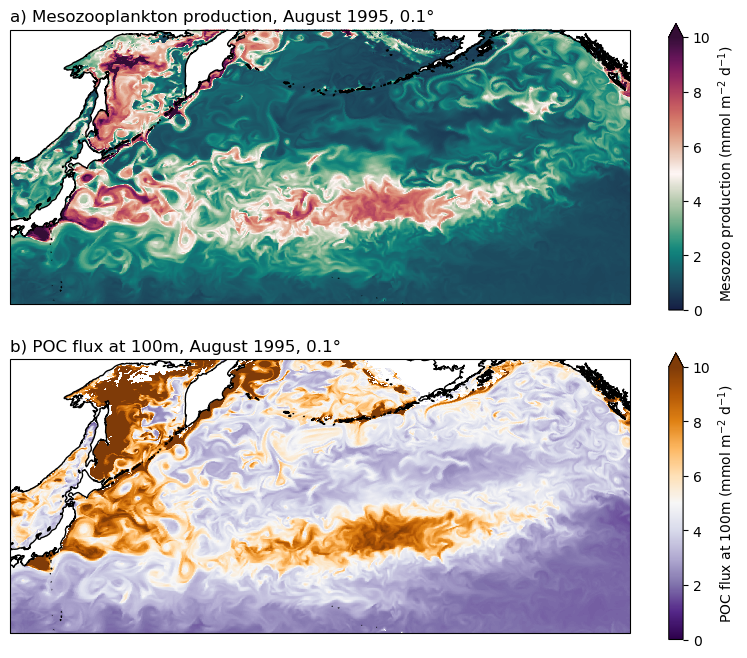

In [12]:
fig = plt.figure(figsize=(10,8))

ts=7

############### 
ax = fig.add_subplot(2,1,1, projection=ccrs.Robinson(central_longitude=-170))
ax.set_extent([-225, -135, 25, 60], ccrs.PlateCarree())

ax.set_title('a) Mesozooplankton production, August 1995, 0.1°', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_fosi_x01.x_graze_mesozoo_zint.isel(time=ts)*0.01*86400.)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cmocean.cm.curl,
                   vmin=0,vmax=10)
ax.coastlines('10m',linewidth=1)

cbar1 = fig.colorbar(pc,extend='max',label='Mesozoo production (mmol m$^{-2}$ d$^{-1}$)')

############### 
ax = fig.add_subplot(2,1,2, projection=ccrs.Robinson(central_longitude=-170))
ax.set_extent([-225, -135, 25, 60], ccrs.PlateCarree())

ax.set_title('b) POC flux at 100m, August 1995, 0.1°', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_fosi_x01.POC_FLUX_100m.isel(time=ts)*0.01*86400.)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='PuOr_r',
                   vmin=0,vmax=10)
ax.coastlines('10m',linewidth=1)

fig.subplots_adjust(hspace=0.15)

# fig.subplots_adjust(right=0.82,wspace=0.05)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar1 = fig.colorbar(pc,extend='max',label='POC flux at 100m (mmol m$^{-2}$ d$^{-1}$)')

#fig.savefig('/glade/work/kristenk/figs/Mesozoo_prod_POC_flux_Npac.png', bbox_inches='tight', dpi=300, format='png');

### Get fish!

In [13]:
path = '/glade/campaign/cgd/oce/projects/FOSI_BGC/HR/'+case+'/FEISTY/FEISTY_'+case+'_199501-199512.nc'

ds_oneyear_feisty = xr.open_dataset(path)

In [14]:
fish_prod_Aug = ds_oneyear_feisty.production.sum(dim='fish').isel(time=7)

In [15]:
ds_oneyear_feisty.group

<xarray.DataArray 'group' (group: 9)>
array(['Sf', 'Sp', 'Sd', 'Mf', 'Mp', 'Md', 'Lp', 'Ld', 'benthic_prey'],
      dtype=object)
Coordinates:
  * group    (group) object 'Sf' 'Sp' 'Sd' 'Mf' ... 'Lp' 'Ld' 'benthic_prey'

In [16]:
fish_biomass_Aug = ds_oneyear_feisty.biomass.sum(dim='group').isel(time=7) - ds_oneyear_feisty.biomass.sel(group='benthic_prey').isel(time=7)

In [17]:
fish_cmap=cmocean.cm.dense

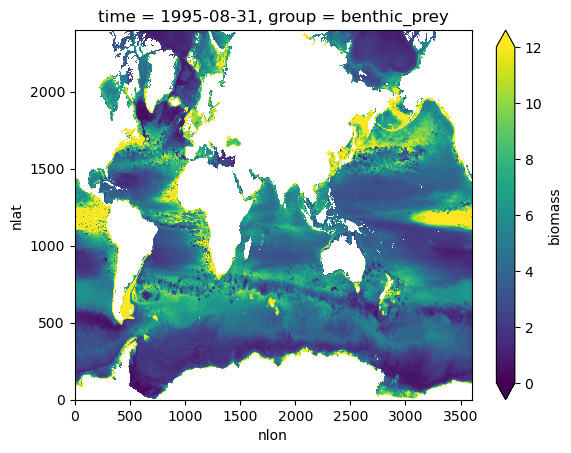

In [18]:
fish_biomass_Aug.plot(vmin=0,vmax=12)

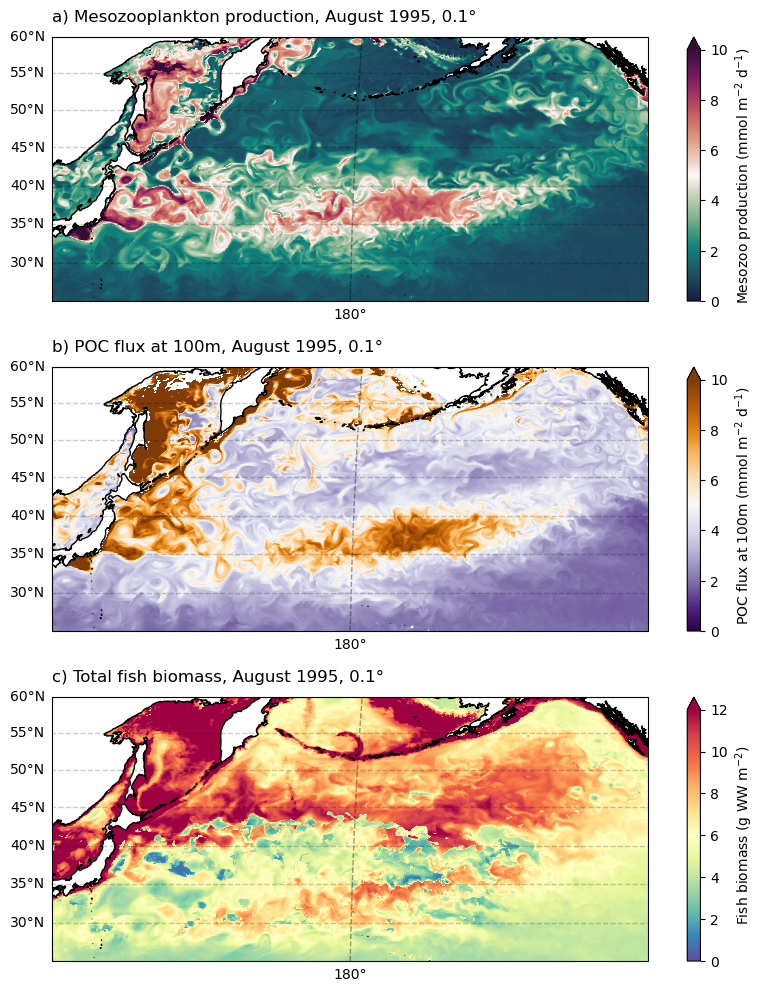

In [ ]:
fig = plt.figure(figsize=(10,12))

ts=7

############### 
ax = fig.add_subplot(3,1,1, projection=ccrs.Robinson(central_longitude=-170))
ax.set_extent([-225, -135, 25, 60], ccrs.PlateCarree())

ax.set_title('a) Mesozooplankton production, August 1995, 0.1°', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_fosi_x01.x_graze_mesozoo_zint.isel(time=ts)*0.01*86400.)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cmocean.cm.curl,
                   vmin=0,vmax=10)
ax.coastlines('10m',linewidth=1)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False


cbar1 = fig.colorbar(pc,extend='max',label='Mesozoo production (mmol m$^{-2}$ d$^{-1}$)')

############### 
ax = fig.add_subplot(3,1,2, projection=ccrs.Robinson(central_longitude=-170))
ax.set_extent([-225, -135, 25, 60], ccrs.PlateCarree())

ax.set_title('b) POC flux at 100m, August 1995, 0.1°', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_fosi_x01.POC_FLUX_100m.isel(time=ts)*0.01*86400.)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='PuOr_r',
                   vmin=0,vmax=10)
ax.coastlines('10m',linewidth=1)

fig.subplots_adjust(hspace=0.15)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False

cbar1 = fig.colorbar(pc,extend='max',label='POC flux at 100m (mmol m$^{-2}$ d$^{-1}$)')


############### 
ax = fig.add_subplot(3,1,3, projection=ccrs.Robinson(central_longitude=-170))
ax.set_extent([-225, -135, 25, 60], ccrs.PlateCarree())

ax.set_title('c) Total fish biomass, August 1995, 0.1°', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, fish_biomass_Aug)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='Spectral_r', #fish_cmap,
                   vmin=0,vmax=12
                  )
ax.coastlines('10m',linewidth=1)

fig.subplots_adjust(hspace=0.25)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False

cbar1 = fig.colorbar(pc,extend='max',label='Fish biomass (g WW m$^{-2}$)') #d$^{-1}$)')

fig.savefig('/glade/work/kristenk/figs/Mesozoo_prod_POC_flux_fish_Npac.png', bbox_inches='tight', dpi=300, format='png');